Quickstart
======

Step by step explanation
----------------------------

### Defining a model


To do model selection, we first need some models. A model, in the simplest case,
is just a callable which takes a single `dict` as input and returns a single `dict` as output. The keys of the input dictionary are the parameters of the model, the output
keys denote the summary statistics.
Here, the `dict` is passed as `parameters` and has the entry `x`, which denotes the mean of a Gaussian.
It returns the observed summary statistics `y`, which is just the sampled value.

In [1]:
import sys 
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel

In [27]:
sample_size = 5
ntest = 10

k2 = 2.
theta2 = 1.0

k3 = 2.
theta3 = 2. 

# then the scale of the Gamma prior for the Poisson is given by
theta1 = 2.0
k1 = (k2 * theta2 * k3 * theta3) / theta1
print(k1)

4.0


In [51]:
%matplotlib inline
import os
import tempfile

import scipy.stats as st

from pyabc import (ABCSMC, RV, Distribution, 
                   PercentileDistanceFunction, sampler)

# Define a gaussian model
sigma = 1.


def Poisson_model(parameters):
    x = scipy.stats.poisson.rvs(parameters.lam, size=sample_size)
    return {'y1': x.mean(), 'y2': x.var()}

def NB_model(parameters): 
    lams = scipy.stats.gamma.rvs(a=parameters.k, scale=parameters.theta, size=sample_size)
    x = scipy.stats.poisson.rvs(lams)
    return {'y1': x.mean(), 'y2': x.var()}

For model selection we usually have more than one model.
These are assembled in a list. We
require a Bayesian prior over the models.
The default is to have a uniform prior over the model classes.
This concludes the model definition.

In [52]:
# We define two models, but they are identical so far
models = [Poisson_model, NB_model]


# Define priors 
prior1 = Distribution.from_dictionary_of_dictionaries(dict(lam={'type': 'gamma', 'kwargs': {'a':k1, 'scale': theta1}}))

prior2 = Distribution.from_dictionary_of_dictionaries(dict(k={'type': 'gamma', 'kwargs': {'a':k2, 'scale': theta2}}, 
                                                     theta={'type': 'gamma', 'kwargs': {'a':k3, 'scale': theta3}}))

parameter_priors = [prior1, prior2]

### Configuring the ABCSMC run

Having the models defined, we can plug together the `ABCSMC` class.
We need a distance function,
to measure the distance of obtained samples.

In [53]:
# We plug all the ABC options together
abc = ABCSMC(
    models, parameter_priors,
    PercentileDistanceFunction(measures_to_use=["y1", "y2"]))

### Setting the observed data

Actually measured data can now be passed to the ABCSMC.
This is set via the `new` method, indicating that we start
a new run as opposed to resuming a stored run (see the "resume stored run" example).
Moreover, we have to set the output database where the ABC-SMC run
is logged.

In [55]:
# y_observed is the important piece here: our actual observation.
y_observed = np.array([3.4 ,5.04])
# and we define where to store the results
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
abc_id = abc.new(db_path, {"y1": y_observed[0], "y2": y_observed[1]})

INFO:History:Start <ABCSMC(id=116, start_time=2018-12-14 17:31:46.948339, end_time=None)>
INFO:Epsilon:initial epsilon is 0.5794672075017542


The `new` method returns an id, which is the id of the
ABC-SMC run in the database.
We're not usint this id for now.
But it might be important when you load the stored data or want
to continue an ABC-SMC run in the case of having more than one
ABC-SMC run stored in a single database.

In [56]:
print("ABC-SMC run ID:", abc_id)

ABC-SMC run ID: 116


### Running the ABC

We run the `ABCSMC` specifying the epsilon value at which to terminate.
The default epsilon strategy is the `pyabc.epsilon.MedianEpsilon`.
Whatever is reached first, the epsilon or the maximum number allowed populations,
terminates the ABC run. The method returns a `pyabc.storage.History` object, which
can, for example, be queried for the posterior probabilities.

In [57]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.0001, max_nr_populations=20)

INFO:ABC:t:0 eps:0.5794672075017542
INFO:ABC:t:1 eps:0.3320118424235006
INFO:ABC:t:2 eps:0.22041302938971094
INFO:ABC:t:3 eps:0.15478415551851277
INFO:ABC:t:4 eps:0.10880266925316881
INFO:ABC:t:5 eps:0.08874669562771549
INFO:ABC:t:6 eps:0.057929965352752064
INFO:ABC:t:7 eps:0.04102923762622772
INFO:ABC:t:8 eps:0.03190810465858325
INFO:ABC:t:9 eps:0.015954052329291618
INFO:ABC:t:10 eps:3.542511246410837e-17
INFO:History:Done <ABCSMC(id=116, start_time=2018-12-14 17:31:46.948339, end_time=2018-12-14 17:32:19.550737)>


Note that the history object is also always accessible from the abcsmc object:

In [59]:
history.total_nr_simulations

146644

In [60]:
# Evaluate the model probabililties
model_probabilities = history.get_model_probabilities()
model_probabilities

m,0,1
t,,
0,0.580000,0.420000
1,0.480828,0.519172
2,0.479587,0.520413
3,0.506062,0.493938
4,0.448775,0.551225
5,0.389643,0.610357
6,0.420484,0.579516
7,0.307510,0.692490
8,0.656609,0.343391


And now, let's visualize the results:

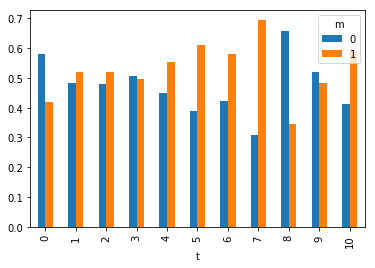

In [61]:
model_probabilities.plot.bar();

So model 1 is the more probable one. Which is expected as it was centered at 1 and the observed data was also 1, whereas model 0 was centered at 0, which is farther away from the observed data. 

In [ ]:
# Save results 
result_dict = dict(mprobsdf=model_probabilities)